In [2]:
%matplotlib inline
import scanpy as sc
import numpy as np
from sklearn import preprocessing
from scipy.sparse import csr_matrix, load_npz
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.append('../')


from pyWNN import pyWNN

## Load in bone marrow data provided by SEURAT with tutorial for WNN analysis
- this was processed in test_Seurat_WNN.Rmd so that there would be a baseline to compare with to check our results are correct

In [27]:
adtfn = '../../../Data/Misc/TestWNN/bm_adt.h5ad'
rnafn = '../../../Data/Misc/TestWNN/bm_rna_2.h5ad'
adt200fn = '../../../Data/Misc/TestWNN/bm_adt_200NN.h5ad'
rna200fn = '../../../Data/Misc/TestWNN/bm_rna_200NN.h5ad'

In [28]:
adata_adt = sc.read(adtfn)
adata_adt

/PHShome/dk718/anaconda3/envs/py38_R411/lib/python3.8/site-packages/anndata/compat/__init__.py:180: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(


AnnData object with n_obs × n_vars = 30672 × 25
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ADT', 'nFeature_ADT', 'lane', 'donor', 'celltype.l1', 'celltype.l2', 'RNA.weight', 'NNdist_PCA', 'NNdist_APCA', 'ADT.weight'
    var: 'features'
    uns: 'neighbors'
    obsm: 'X_apca', 'X_apca.norm'
    varm: 'APCA'
    obsp: 'distances'

In [29]:
adata_adt200 = sc.read(adt200fn)
adata_adt200

AnnData object with n_obs × n_vars = 30672 × 25
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ADT', 'nFeature_ADT', 'lane', 'donor', 'celltype.l1', 'celltype.l2', 'RNA.weight', 'ADT.weight'
    var: 'features'
    uns: 'neighbors'
    obsm: 'X_apca'
    varm: 'APCA'
    obsp: 'distances'

In [30]:
adata_rna200 = sc.read(rna200fn)
adata_rna200

AnnData object with n_obs × n_vars = 30672 × 2000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ADT', 'nFeature_ADT', 'lane', 'donor', 'celltype.l1', 'celltype.l2', 'RNA.weight', 'ADT.weight'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable'
    uns: 'neighbors'
    obsm: 'X_pca'
    varm: 'PCs'
    obsp: 'distances'

In [8]:
adata_seurat = sc.read(rnafn)
adata_seurat.obsm['X_rna_pca'] = adata_seurat.obsm.pop('X_pca')
_ = adata_seurat.obsm.pop('X_pca.norm')
adata_seurat.obsm['X_adt_pca'] = adata_adt.obsm['X_apca']
adata_py = adata_seurat.copy()

adata_seurat.obsp['rna_distances_K20'] = csr_matrix(adata_seurat.obsp['distances'].transpose())
adata_seurat.obsp['adt_distances_K20'] = csr_matrix(adata_adt.obsp['distances'].transpose())
adata_seurat.obsp['rna_distances_K200'] = csr_matrix(adata_rna200.obsp['distances'].transpose())
adata_seurat.obsp['adt_distances_K200'] = csr_matrix(adata_adt200.obsp['distances'].transpose())

adata_seurat.obsp['rna_distances_K20'].eliminate_zeros()
adata_seurat.obsp['adt_distances_K20'].eliminate_zeros()
adata_seurat.obsp['rna_distances_K200'].eliminate_zeros()
adata_seurat.obsp['adt_distances_K200'].eliminate_zeros()

In [9]:
adata_seurat.uns = dict()
adata_py.uns = dict()

In [10]:
del(adata_adt200, adata_rna200, adata_adt)

## Run WNN using the KNN distance matrices as calculated by R/SEURAT for exact compatibility

In [15]:
WNNobj = pyWNN(adata_seurat, reps=['X_rna_pca', 'X_adt_pca'], npcs=[30,18], distances=['rna_distances_K20', 'adt_distances_K20', 'rna_distances_K200', 'adt_distances_K200'])
adata_seurat = WNNobj.compute_wnn(adata_seurat)

/PHShome/dk718/anaconda3/envs/py38_R411/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


0 out of 30672 0.00 seconds elapsed
2000 out of 30672 11.76 seconds elapsed
4000 out of 30672 23.37 seconds elapsed
6000 out of 30672 35.02 seconds elapsed
8000 out of 30672 46.62 seconds elapsed
10000 out of 30672 58.32 seconds elapsed
12000 out of 30672 69.94 seconds elapsed
14000 out of 30672 81.65 seconds elapsed
16000 out of 30672 93.25 seconds elapsed
18000 out of 30672 105.36 seconds elapsed
20000 out of 30672 119.78 seconds elapsed
22000 out of 30672 134.76 seconds elapsed
24000 out of 30672 149.78 seconds elapsed
26000 out of 30672 164.87 seconds elapsed
28000 out of 30672 179.89 seconds elapsed
30000 out of 30672 195.01 seconds elapsed


In [16]:
sc.tl.umap(adata_seurat, neighbors_key='WNN')

/PHShome/dk718/anaconda3/envs/py38_R411/lib/python3.8/site-packages/umap/spectral.py:319: RuntimeWarning: divide by zero encountered in true_divide
  1.0 / np.sqrt(diag_data), 0, graph.shape[0], graph.shape[0]


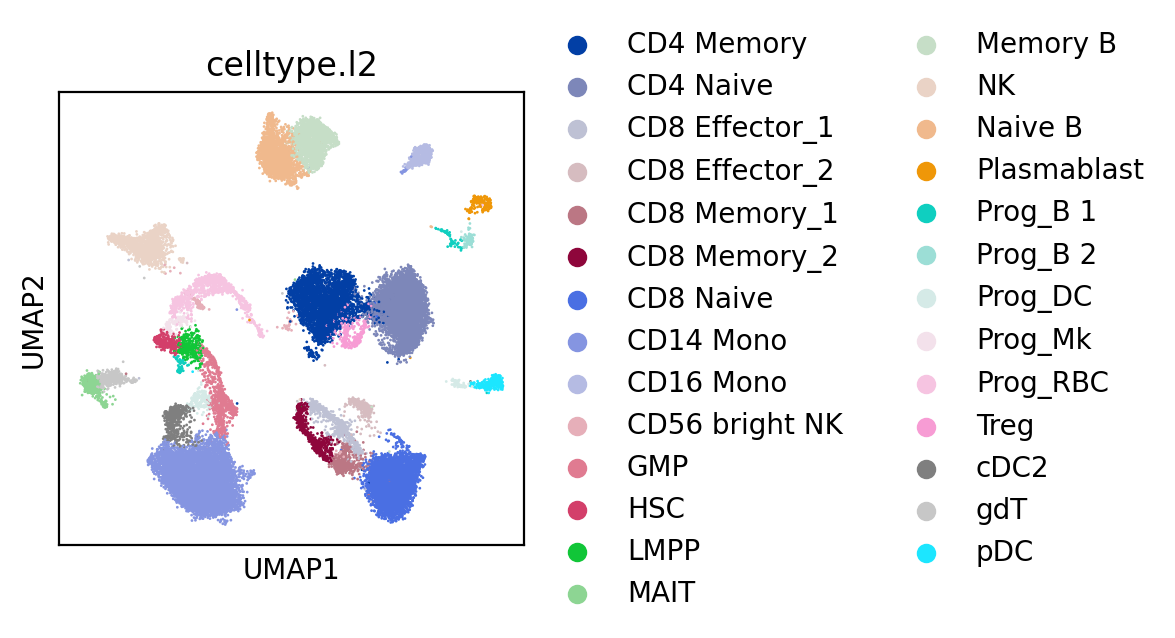

In [18]:
(fig,ax) = plt.subplots(1,1, figsize=(3,3), dpi=200)
sc.pl.umap(adata_seurat, color='celltype.l2', ax=ax)

In [28]:
adata_adt = sc.read(adtfn)
adata_adt
adata_seurat.obs['AB_CD4'] = adata_adt.X[:,adata_adt.var['features']=='CD4'].reshape(-1)
adata_seurat.obs['AB_CD8'] = adata_adt.X[:,adata_adt.var['features']=='CD8a'].reshape(-1)
adata_seurat.obs['AB_CD34'] = adata_adt.X[:,adata_adt.var['features']=='CD34'].reshape(-1)

adata_seurat.obs['AB_CD45RA'] = adata_adt.X[:,adata_adt.var['features']=='CD45RA'].reshape(-1)
adata_seurat.obs['AB_CD45RO'] = adata_adt.X[:,adata_adt.var['features']=='CD45RO'].reshape(-1)

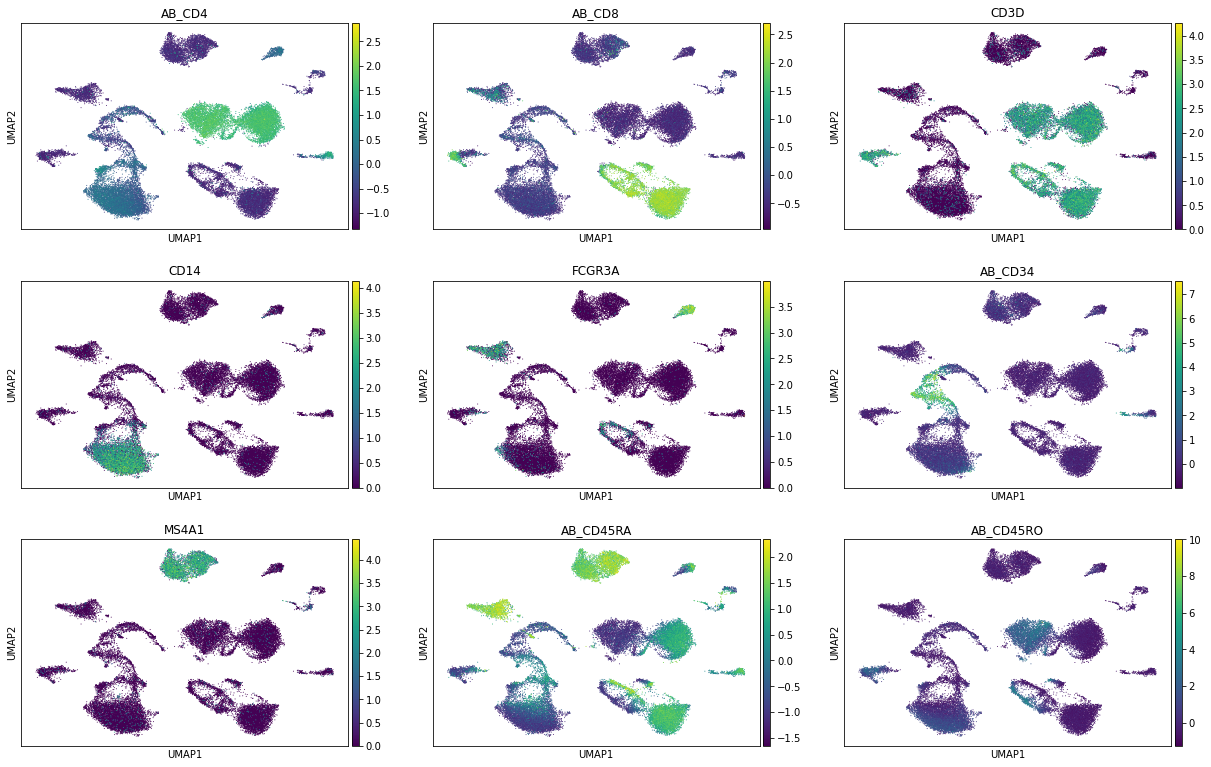

In [29]:
sc.pl.umap(adata_seurat, color=['AB_CD4', 'AB_CD8', 'CD3D',
                                'CD14', 'FCGR3A', 'AB_CD34',
                                'MS4A1', 'AB_CD45RA', 'AB_CD45RO'], ncols=3)

In [30]:
WNNobj = pyWNN(adata_py, reps=['X_rna_pca', 'X_adt_pca'], npcs=[30,18], distances=None)
adata_py = WNNobj.compute_wnn(adata_py)

Computing KNN distance matrices using default Scanpy implementation


/PHShome/dk718/anaconda3/envs/py38_R411/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Computing modality weights
Computing weighted distances for union of 200 nearest neighbors between modalities
0 out of 30672 0.01 seconds elapsed
2000 out of 30672 11.68 seconds elapsed
4000 out of 30672 23.30 seconds elapsed
6000 out of 30672 34.93 seconds elapsed
8000 out of 30672 46.56 seconds elapsed
10000 out of 30672 58.15 seconds elapsed
12000 out of 30672 69.83 seconds elapsed
14000 out of 30672 81.45 seconds elapsed
16000 out of 30672 93.01 seconds elapsed
18000 out of 30672 104.55 seconds elapsed
20000 out of 30672 116.21 seconds elapsed
22000 out of 30672 127.85 seconds elapsed
24000 out of 30672 139.42 seconds elapsed
26000 out of 30672 151.05 seconds elapsed
28000 out of 30672 162.65 seconds elapsed
30000 out of 30672 174.25 seconds elapsed
Selecting top K neighbors


In [31]:
sc.tl.umap(adata_py, neighbors_key='WNN')

/PHShome/dk718/anaconda3/envs/py38_R411/lib/python3.8/site-packages/umap/spectral.py:319: RuntimeWarning: divide by zero encountered in true_divide
  1.0 / np.sqrt(diag_data), 0, graph.shape[0], graph.shape[0]


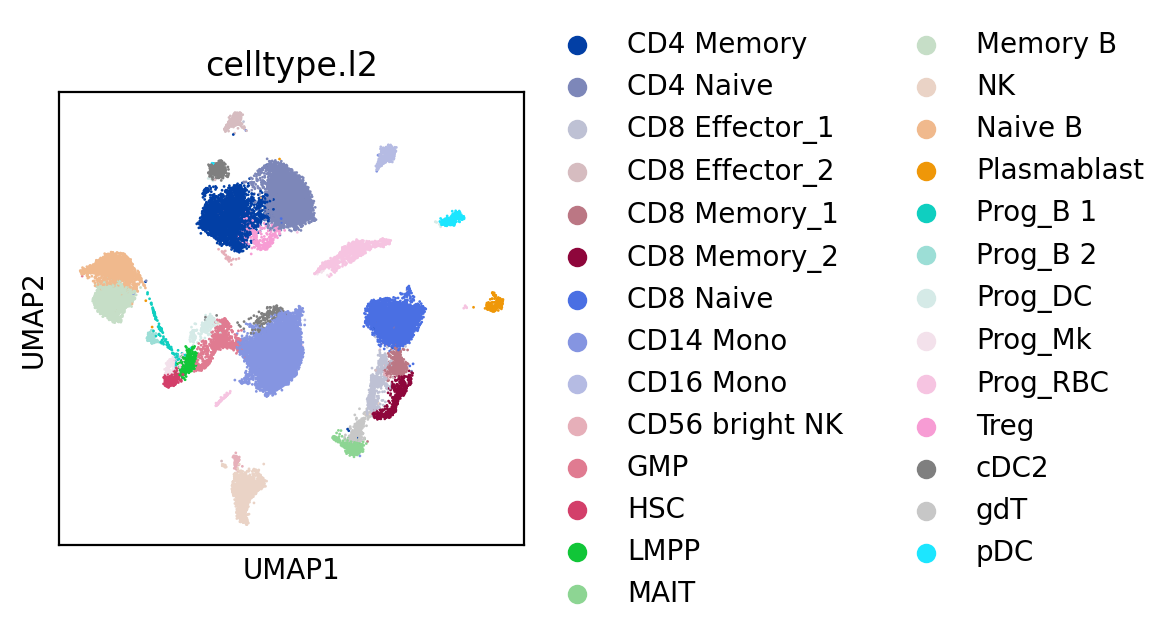

In [32]:
(fig,ax) = plt.subplots(1,1, figsize=(3,3), dpi=200)
sc.pl.umap(adata_py, color='celltype.l2', ax=ax)

In [33]:
adata_py.obs['AB_CD4'] = adata_adt.X[:,adata_adt.var['features']=='CD4'].reshape(-1)
adata_py.obs['AB_CD8'] = adata_adt.X[:,adata_adt.var['features']=='CD8a'].reshape(-1)
adata_py.obs['AB_CD34'] = adata_adt.X[:,adata_adt.var['features']=='CD34'].reshape(-1)

adata_py.obs['AB_CD45RA'] = adata_adt.X[:,adata_adt.var['features']=='CD45RA'].reshape(-1)
adata_py.obs['AB_CD45RO'] = adata_adt.X[:,adata_adt.var['features']=='CD45RO'].reshape(-1)

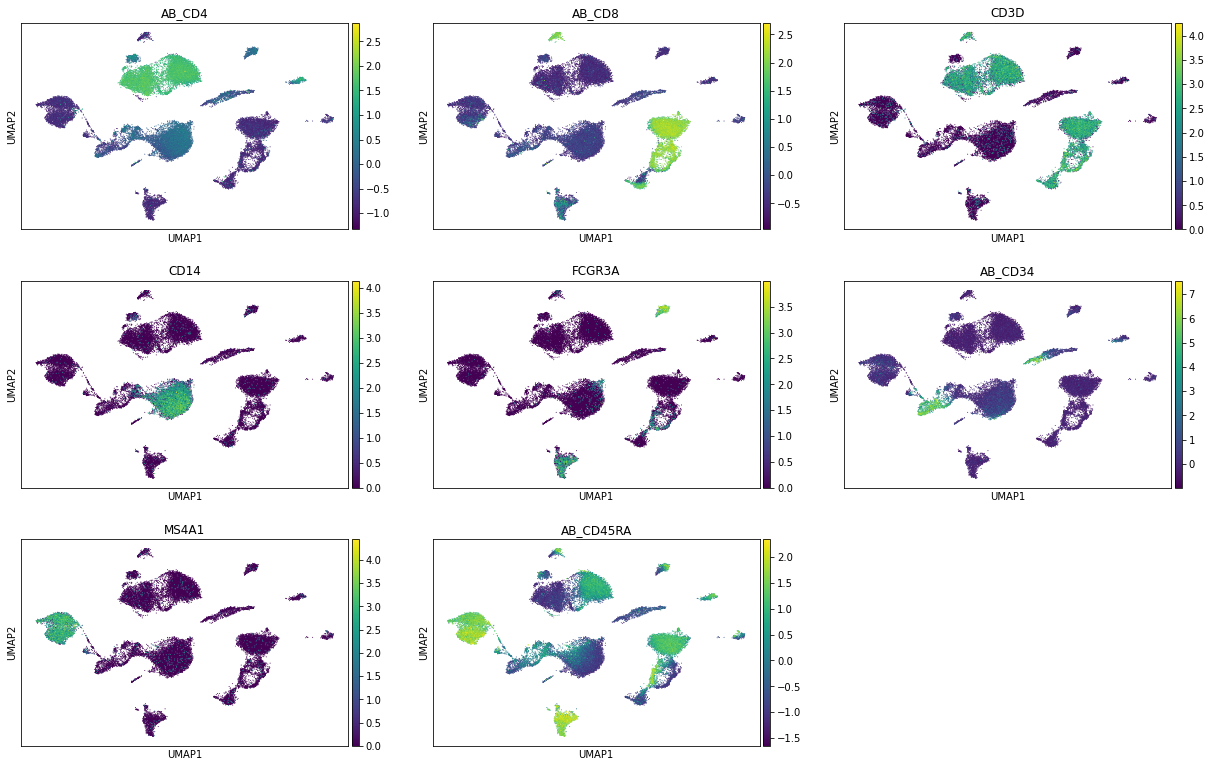

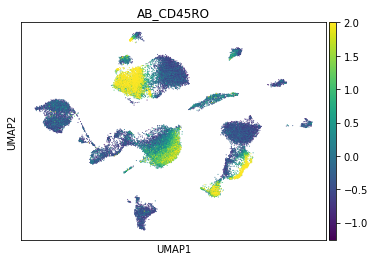

In [36]:
sc.pl.umap(adata_py, color=['AB_CD4', 'AB_CD8', 'CD3D',
                                'CD14', 'FCGR3A', 'AB_CD34',
                                'MS4A1', 'AB_CD45RA'], ncols=3)
                            
                            
sc.pl.umap(adata_py, color='AB_CD45RO', vmax=2)